In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

### 1. Collect Data

In [2]:
# Get data from local database
connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=DESKTOP-FK1AJ2V;Trusted_Connection=yes;')
cursor = connection.cursor()

# Get list of transfers
query = """
SELECT * FROM la_liga_transfers..transfers_from_api
"""
cursor.execute(query)
results = cursor.fetchall()
df_transfers = pd.read_sql(query, connection)

# Get stats for players
query = """
SELECT * FROM la_liga_transfers..stats_from_season_2015
"""
cursor.execute(query)
results = cursor.fetchall()
df_stats = pd.read_sql(query, connection)

for season in range(2016, 2023):
    query = f"""
    SELECT * FROM la_liga_transfers..stats_from_season_{season}
    """
    cursor.execute(query)
    results = cursor.fetchall()
    df_stats = df_stats.append(pd.read_sql(query, connection), ignore_index=True)
    
# Get list of spanish teams
query = """
SELECT * FROM la_liga_transfers..teams_from_Spain
"""
cursor.execute(query)
results = cursor.fetchall()
df_spanish_teams = pd.read_sql(query, connection)

cursor.close()
connection.close()


C:\Users\Adrian\AppData\Local\Temp\ipykernel_7092\1763652232.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_transfers = pd.read_sql(query, connection)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_7092\1763652232.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_stats = pd.read_sql(query, connection)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_7092\1763652232.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_stats = df_stats.append(pd.read_sql(query, connection), ignore_index=True)
C:\Users\Adrian\AppDa

### 2. Data wrangling / Data cleaning

#### 2.1. {df_transfers} cleaning

In [3]:
df_transfers.info()
df_transfers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27994 entries, 0 to 27993
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   F1                        27994 non-null  float64
 1   player#id                 27994 non-null  float64
 2   player#name               27993 non-null  object 
 3   transfers#date            27903 non-null  object 
 4   transfers#type            27439 non-null  object 
 5   transfers#teams#in#id     24586 non-null  object 
 6   transfers#teams#in#name   27711 non-null  object 
 7   transfers#teams#in#logo   27703 non-null  object 
 8   transfers#teams#out#id    24265 non-null  object 
 9   transfers#teams#out#name  27747 non-null  object 
 10  transfers#teams#out#logo  27741 non-null  object 
dtypes: float64(2), object(9)
memory usage: 2.3+ MB


,F1,player#id,player#name,transfers#date,transfers#type,transfers#teams#in#id,transfers#teams#in#name,transfers#teams#in#logo,transfers#teams#out#id,transfers#teams#out#name,transfers#teams#out#logo
0,157.0,47203.0,Jaime Romero,2018-07-01 00:00:00,N/A,713.0,Cordoba,https://media-3.api-sports.io/football/teams/7...,716.0,Lugo,https://media-1.api-sports.io/football/teams/7...
1,158.0,47203.0,Jaime Romero,2018-01-17 00:00:00,Loan,716.0,Lugo,https://media-3.api-sports.io/football/teams/7...,713.0,Cordoba,https://media-2.api-sports.io/football/teams/7...
2,159.0,122740.0,J. Torres,2020-08-22 00:00:00,N/A,860.0,Extremadura,https://media-3.api-sports.io/football/teams/8...,716.0,Lugo,https://media-2.api-sports.io/football/teams/7...
3,160.0,122740.0,J. Torres,2019-08-30 00:00:00,Loan,8157.0,FC Andorra,https://media-1.api-sports.io/football/teams/8...,716.0,Lugo,https://media-2.api-sports.io/football/teams/7...
4,161.0,122740.0,J. Torres,2019-08-29 00:00:00,N/A,716.0,Lugo,https://media-3.api-sports.io/football/teams/7...,5268.0,Melilla,https://media-2.api-sports.io/football/teams/5...


In [3]:
# Drop unnecessary columns
df_transfers = df_transfers.drop(['F1', 'transfers#teams#in#logo', 'transfers#teams#out#logo'], axis=1)

# Get rid of duplicated rows
df_transfers.drop_duplicates(inplace=True)

# Rename column names
df_transfers.columns = [col.replace('#', '_') for col in df_transfers.columns]

# Drop empty data from 'teams in' columns
df_transfers = df_transfers.dropna(subset=['transfers_teams_in_id', 'transfers_teams_in_id'])

##### Convert values in 'transfers_type' column

In [4]:
# Drop loan and swap transfers
df_transfers = df_transfers.dropna(subset='transfers_type')
valtodrop = ['Loan', 'End of Loan', 'Swap']
df_transfers = df_transfers[df_transfers['transfers_type'].isin(valtodrop) == False]

In [5]:
# Replace all data marked as "free" to value 0.0
df_transfers['transfers_type'] = np.where(df_transfers['transfers_type'].str.contains('free', case=False, na=False, regex=False), 0.0, df_transfers['transfers_type'])

# Replace all data marked as N/A to None
df_transfers['transfers_type'] = np.where(df_transfers['transfers_type'].str.contains('N/A', case=False, na=False, regex=False), np.nan, df_transfers['transfers_type'])

In [6]:
# Function to convert transfers fee expressed as STRING to FLOAT
def convert_to_number(value: str) -> float:
    value = value.upper().rstrip()
    if 'M' in value:
        return round(float(value.strip('M')), 2)
    elif 'K' in value:
        return round(float(value.strip('K')) / 1000, 2)
    else:
        return value
    
# List comprehension to transform data to transfers_fee in EU (exchange rate valid on 25.06.23)
df_transfers['transfers_type'] = [convert_to_number((value).strip('$')) * 0.92 if isinstance(value, str) and '$' in value else 
                                  convert_to_number((value).strip('€')) if isinstance(value, str) and '€' in value else 
                                  convert_to_number(value) if isinstance(value, str) else
                                  value for value in df_transfers['transfers_type']]

df_transfers = df_transfers.rename(columns={'transfers_type': 'transfer_fee'})

In [7]:
# Change columns types
df_transfers['player_id'] = df_transfers['player_id'].astype('int')
df_transfers['transfers_teams_in_id'] = pd.to_numeric(df_transfers['transfers_teams_in_id']).astype('int')
df_transfers['transfers_date'] = pd.to_datetime(df_transfers['transfers_date'], errors='coerce') 

# Reset indexes
df_transfers = df_transfers.reset_index(drop=True)

##### Create new column for season of transfer

In [8]:
"""
# Season 2018 is 2018/2019
# Summer transfer window is 18-07-01 - 18-09-01
# Winter transfer window is 19-01-02 - 19-02-01
# 
# So for every year:
# January, February, March - season of transfer is ({year} - 1)
# April to December        - season of transfer is {year}
"""

df_transfers['season_of_transfer'] = np.where(df_transfers['transfers_date'].dt.month.isin(range(1,4)),
                          df_transfers['transfers_date'].dt.year - 1,
                          df_transfers['transfers_date'].dt.year)

In [9]:
df_transfers.info()
df_transfers.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15991 entries, 0 to 15990
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   player_id                 15991 non-null  int32         
 1   player_name               15991 non-null  object        
 2   transfers_date            15956 non-null  datetime64[ns]
 3   transfer_fee              6105 non-null   float64       
 4   transfers_teams_in_id     15991 non-null  int32         
 5   transfers_teams_in_name   15991 non-null  object        
 6   transfers_teams_out_id    13784 non-null  object        
 7   transfers_teams_out_name  15851 non-null  object        
 8   season_of_transfer        15956 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), object(4)
memory usage: 999.6+ KB


,player_id,player_name,transfers_date,transfer_fee,transfers_teams_in_id,transfers_teams_in_name,transfers_teams_out_id,transfers_teams_out_name,season_of_transfer
0,47203,Jaime Romero,2018-07-01,NaN,713,Cordoba,716.0,Lugo,2018.0
1,122740,J. Torres,2020-08-22,NaN,860,Extremadura,716.0,Lugo,2020.0
2,122740,J. Torres,2019-08-29,NaN,716,Lugo,5268.0,Melilla,2019.0


#### 2.2 {df_stats} cleaning

In [12]:
df_stats.info()
df_stats.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5793 entries, 0 to 5792
Data columns (total 60 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   F1                                5784 non-null   float64       
 1   player#id                         5784 non-null   float64       
 2   player#name                       5790 non-null   object        
 3   player#firstname                  5782 non-null   object        
 4   player#lastname                   5786 non-null   object        
 5   player#age                        5781 non-null   float64       
 6   player#birth#date                 5785 non-null   datetime64[ns]
 7   player#birth#place                5626 non-null   object        
 8   player#birth#country              5784 non-null   object        
 9   player#nationality                5784 non-null   object        
 10  player#height                     5535 non-null 

,F1,player#id,player#name,player#firstname,player#lastname,player#age,player#birth#date,player#birth#place,player#birth#country,player#nationality,...,statistics#fouls#drawn,statistics#fouls#committed,statistics#cards#yellow,statistics#cards#yellowred,statistics#cards#red,statistics#penalty#won,statistics#penalty#commited,statistics#penalty#scored,statistics#penalty#missed,statistics#penalty#saved
0,0.0,367.0,Iker Casillas Fernández,Iker,Casillas Fernández,38.0,1981-05-20,Móstoles,Spain,Spain,...,None,None,0.0,0.0,0.0,None,None,None,None,None
1,1.0,1630.0,M. Musacchio,Mateo Pablo,Musacchio,31.0,1990-08-26,Rosario,Argentina,Argentina,...,9.0,13.0,1.0,0.0,0.0,None,None,0.0,0.0,None
2,2.0,46784.0,Dani Giménez,Daniel,Giménez Hernández,38.0,1983-07-30,Vigo,Spain,Spain,...,0.0,0.0,0.0,0.0,0.0,None,None,0.0,0.0,1.0


In [9]:
# Drop unnecessary columns
col_to_drop = [0, 26, 29, 32] + list(range(6, 9)) + list(range(11, 15)) + list(range(16, 22))
df_stats = df_stats.drop(df_stats.columns[col_to_drop], axis=1)

# Rename column names
df_stats.columns = df_stats.columns.str.replace('#', '_')

# Get rid of duplicated rows
df_stats.drop_duplicates(inplace=True)

# Drop rows with None values in 'team_name'
mask = df_stats['statistics_team_name'].isna()
df_stats = df_stats.drop(df_stats[mask].index)

In [10]:
# Change  columns types
df_stats[df_stats.columns[[0, 4, 8]]] = df_stats[df_stats.columns[[0, 4, 8]]].astype('int')
df_stats[df_stats.columns[list(range(9, 12)) + list(range(13, 43))]] = df_stats[df_stats.columns[list(range(9, 12)) + list(range(13, 43))]].astype('float')

# Convert 'player_height' columns as float
df_stats['player_height'] = df_stats['player_height'].str.rstrip('cm').astype('float') 

In [15]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5723 entries, 0 to 5792
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   player_id                         5723 non-null   int32  
 1   player_name                       5723 non-null   object 
 2   player_firstname                  5723 non-null   object 
 3   player_lastname                   5723 non-null   object 
 4   player_age                        5723 non-null   int32  
 5   player_nationality                5723 non-null   object 
 6   player_height                     5477 non-null   float64
 7   statistics_team_name              5723 non-null   object 
 8   statistics_league_season          5723 non-null   int32  
 9   statistics_games_appearences      5692 non-null   float64
 10  statistics_games_lineups          5692 non-null   float64
 11  statistics_games_minutes          5692 non-null   float64
 12  statis

#### 2.3 Merge data-sets
- {merged_df} - List of players transferred to La liga clubs in the seasons from 2015/16 to 2022/23 and  their statistics in the first season after transfer

In [11]:
merged_df = df_transfers.merge(df_stats, how='inner', 
                               left_on=['player_id', 'player_name', 'transfers_teams_in_name', 'season_of_transfer'],
                               right_on=['player_id', 'player_name', 'statistics_team_name', 'statistics_league_season'])

In [13]:
merged_df.info()
merged_df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 0 to 1289
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   player_id                         1290 non-null   int32         
 1   player_name                       1290 non-null   object        
 2   transfers_date                    1290 non-null   datetime64[ns]
 3   transfer_fee                      721 non-null    float64       
 4   transfers_teams_in_id             1290 non-null   int32         
 5   transfers_teams_in_name           1290 non-null   object        
 6   transfers_teams_out_id            1176 non-null   object        
 7   transfers_teams_out_name          1289 non-null   object        
 8   season_of_transfer                1290 non-null   float64       
 9   player_firstname                  1290 non-null   object        
 10  player_lastname                   1290 non-null 

,player_id,player_name,transfers_date,transfer_fee,transfers_teams_in_id,transfers_teams_in_name,transfers_teams_out_id,transfers_teams_out_name,season_of_transfer,player_firstname,...,statistics_fouls_drawn,statistics_fouls_committed,statistics_cards_yellow,statistics_cards_yellowred,statistics_cards_red,statistics_penalty_won,statistics_penalty_commited,statistics_penalty_scored,statistics_penalty_missed,statistics_penalty_saved
0,47404,V. Kravets,2019-01-13,2.0,537,Leganes,716.0,Lugo,2018.0,Vasyl,...,3.0,11.0,2.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1,755,Jaime Seoane,2020-08-04,NaN,726,Huesca,716.0,Lugo,2020.0,Jaime,...,33.0,43.0,5.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2,47253,Ignasi Miquel,2017-12-07,0.5,535,Malaga,716.0,Lugo,2017.0,Ignasi,...,14.0,41.0,5.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN


### 3. Exploratory Data Analysis

#### 3.1 Basic statistics of dataset

In [14]:
# Basic players statistics
selected_columns = ['transfer_fee', 'player_age', 'statistics_games_appearences', 'statistics_games_minutes', 'statistics_games_rating', 'statistics_goals_total', 'statistics_goals_assists']
merged_df[selected_columns].describe().round(2)

,transfer_fee,player_age,statistics_games_appearences,statistics_games_minutes,statistics_games_rating,statistics_goals_total,statistics_goals_assists
count,721.00,1290.00,1288.00,1288.00,1060.00,1288.00,496.00
mean,6.71,30.04,15.30,992.70,6.73,1.36,2.28
std,14.15,4.21,12.18,933.62,0.24,2.72,1.61
min,0.00,19.00,0.00,0.00,4.90,0.00,1.00
25%,0.00,27.00,3.00,90.00,6.60,0.00,1.00
50%,1.50,30.00,15.00,788.50,6.74,0.00,2.00
75%,7.00,33.00,27.00,1710.00,6.89,2.00,3.00
max,126.00,42.00,38.00,3420.00,7.50,23.00,12.00


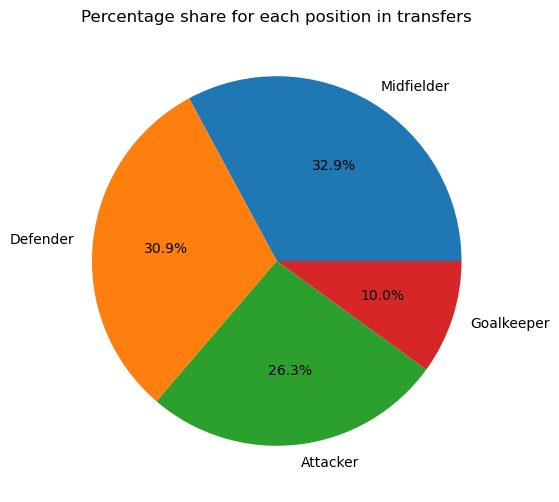

In [13]:
# Percentage share for each position in transfers
position_share = merged_df['statistics_games_position'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6)) 
plt.pie(position_share, labels=position_share.index, autopct='%1.1f%%')

plt.title('Percentage share for each position in transfers')

# Display the chart
plt.show()

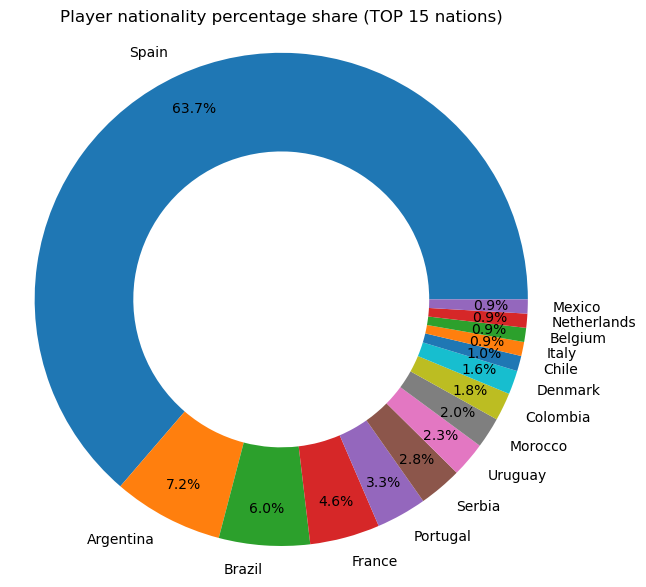

In [19]:
# Percentage share for players nationality in transfers
nationality_share = merged_df['player_nationality'].value_counts(normalize=True) * 100
nationality_share_top = nationality_share.round(2).head(15)

plt.figure(figsize=(7, 7)) 
plt.pie(nationality_share_top, labels=nationality_share_top.index, autopct='%1.1f%%', wedgeprops=dict(width=0.4), pctdistance=0.85)
plt.title('Player nationality percentage share (TOP 15 nations)')
plt.axis('equal')  # Equal aspect ratio ensures the donut shape
plt.show()

#### 3.2 Transfer fee statistics.

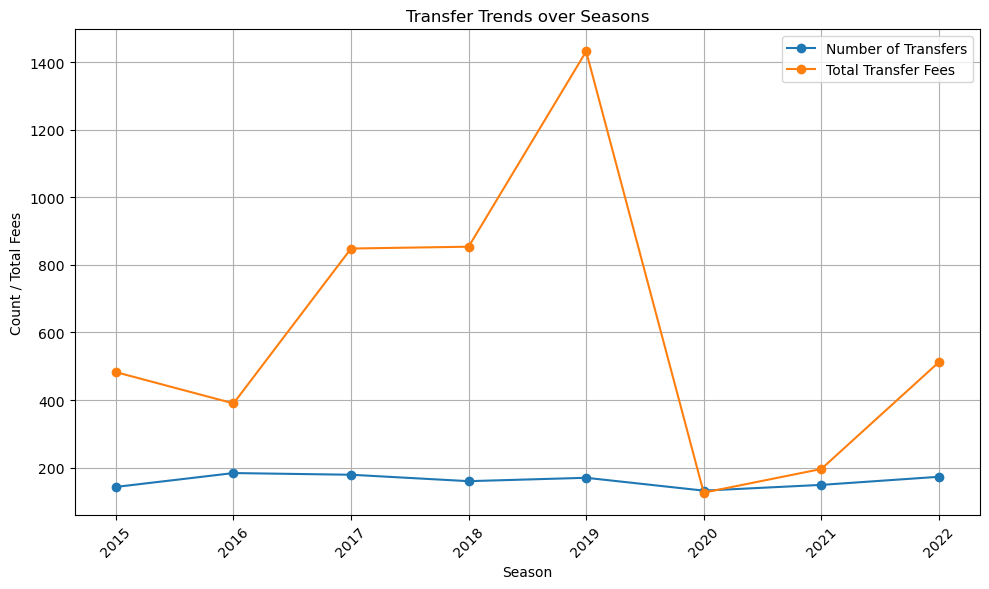

In [106]:
season_agg = merged_df.groupby(by='season_of_transfer').agg({
    'player_id': 'count',
    'transfer_fee': 'sum'
}).reset_index()


plt.figure(figsize=(10, 6))
plt.plot(season_agg['season_of_transfer'], season_agg['player_id'], marker='o', label='Number of Transfers')
plt.plot(season_agg['season_of_transfer'], season_agg['transfer_fee'], marker='o', label='Total Transfer Fees')

plt.xlabel('Season')
plt.ylabel('Count / Total Fees')
plt.title('Transfer Trends over Seasons')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

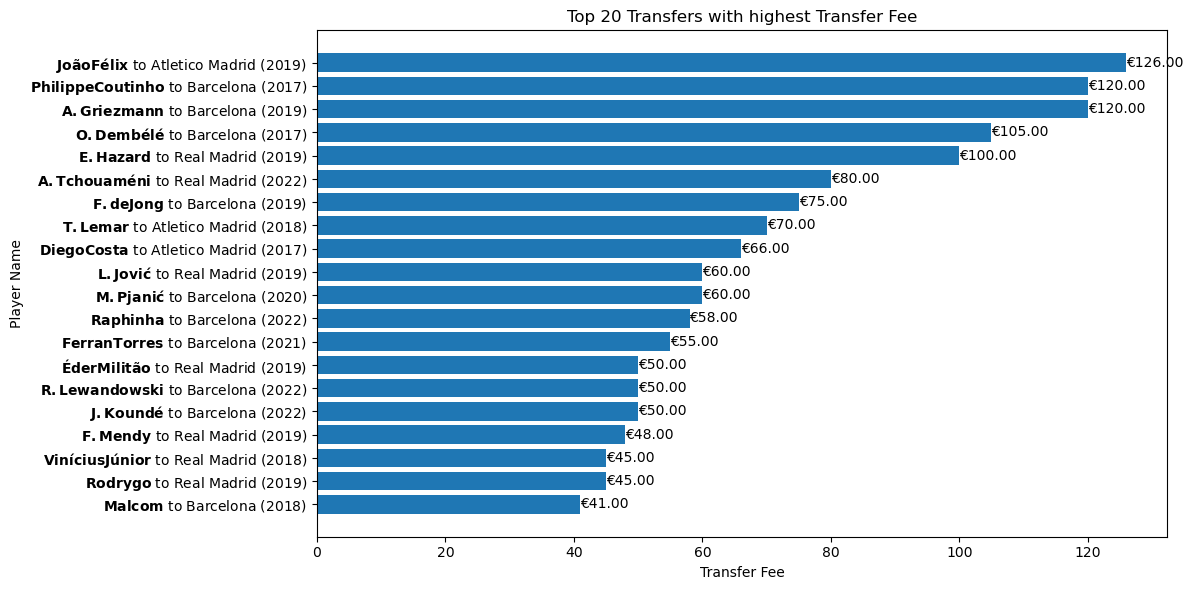

In [14]:
top_transfers = merged_df.sort_values(by='transfer_fee', ascending=False).head(20)

# Create labels for Y-axis
y_labels = [f"$\mathbf{{{name}}}$ to {team} ({int(season)})" for name, team, season in zip(top_transfers['player_name'], top_transfers['transfers_teams_in_name'], top_transfers['season_of_transfer'])]

# Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(y_labels, top_transfers['transfer_fee'])

# Add transfer fee as labels to the bars
for bar, fee in zip(bars, top_transfers['transfer_fee']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{fee:.2f}", va='center')
        
plt.xlabel('Transfer Fee')
plt.ylabel('Player Name')
plt.title('Top 20 Transfers with highest Transfer Fee')
plt.gca().invert_yaxis()  

plt.tight_layout()
plt.show()

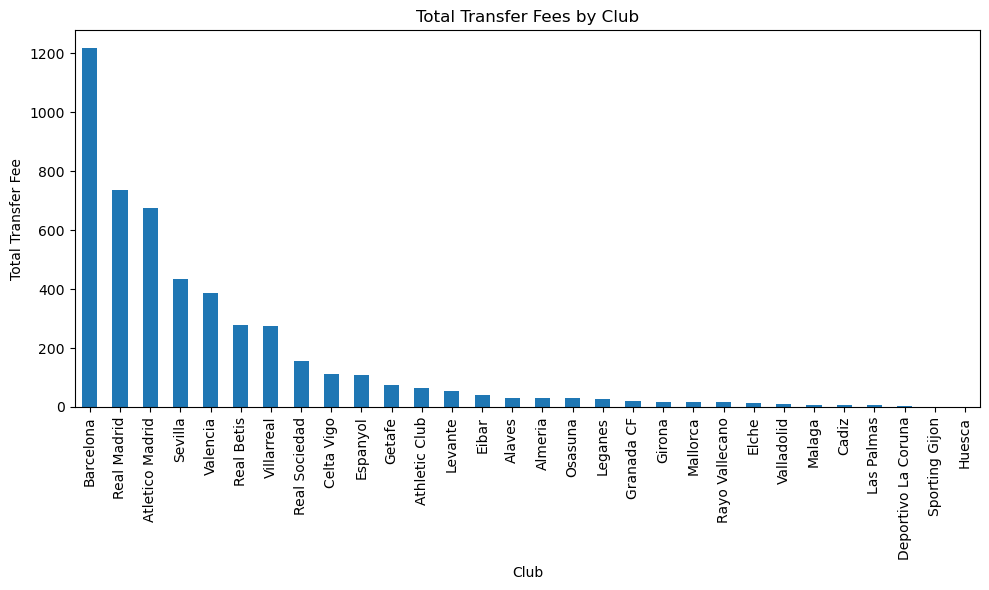

In [24]:
club_transfer_sums = merged_df.groupby(by='transfers_teams_in_name')['transfer_fee'].sum().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
club_transfer_sums.plot(kind='bar')
plt.xlabel('Club')
plt.ylabel('Total Transfer Fee')
plt.title('Total Transfer Fees by Club')
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

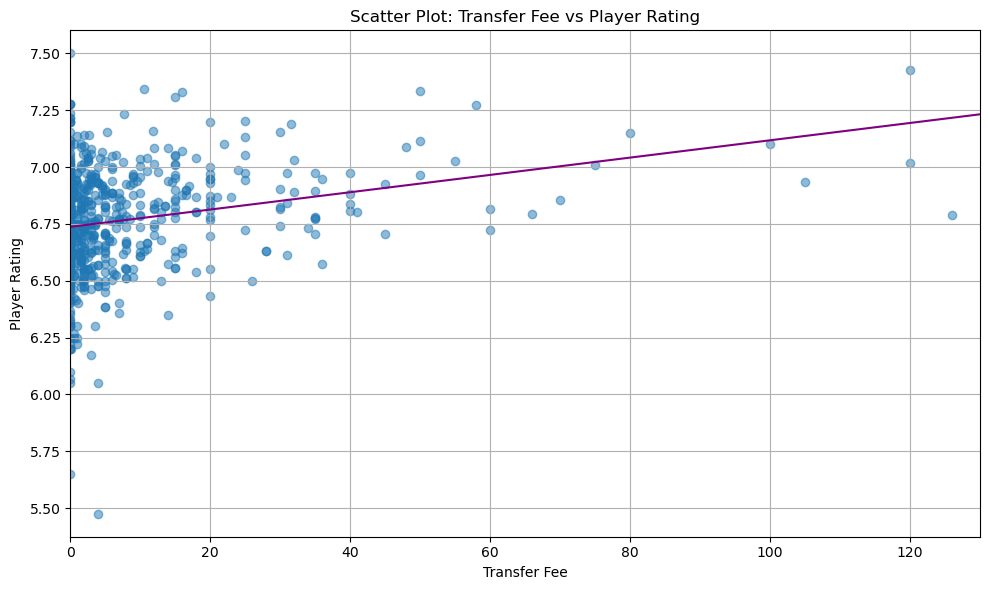

In [23]:
# Filter out rows with missing transfer fees or player ratings
filtered_df = merged_df.dropna(subset=['transfer_fee', 'statistics_games_rating'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['transfer_fee'], filtered_df['statistics_games_rating'], alpha=0.5)
plt.title('Scatter Plot: Transfer Fee vs Player Rating')
plt.xlabel('Transfer Fee')
plt.ylabel('Player Rating')

plt.xlim(0, 130)

# Calculate the trend line using linear regression
slope, intercept, r_value, p_value, std_err = linregress(filtered_df['transfer_fee'], filtered_df['statistics_games_rating'])

x = np.array([0, 130])
y = slope * x + intercept
plt.plot(x, y, color='purple', label='Trend Line')

plt.grid(True)
plt.tight_layout()

plt.show()

#### 3.3 Performance metric

##### Calculate 'performance_metric' parameter to evaluate players performance

In [12]:
# Create DafaFrame that includes data to calculate 'performance_metric'
selected_columns = ['statistics_games_rating', 'statistics_goals_total', 'statistics_goals_assists', 'statistics_passes_key', 'statistics_goals_saves', 'statistics_tackles_total', 'statistics_tackles_interceptions']
weights = [0.25, 0.15, 0.1, 0.1, 0.2, 0.1, 0.1] # assaign weights for parameters in {selected_columns}

performance_data_df = merged_df[selected_columns]
performance_data_df.fillna(0.0, inplace=True)

# Normalize data and calculate 'performance_metric'
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(performance_data_df)

performance_metric = (normalized_data * weights).sum(axis=1)
merged_df['performance_metric'] = performance_metric

C:\Users\Adrian\AppData\Local\Temp\ipykernel_7092\498379215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_data_df.fillna(0.0, inplace=True)


In [13]:
# TOP 10 Transfer based on 'performance_metric'
print("\033[1m" + "TOP 10 Transfer based on 'performance_metric" + "\033[0m")
merged_df.sort_values(by='performance_metric', ascending=False)[['player_name', 'transfers_teams_in_name', 'season_of_transfer', 'transfer_fee', 'performance_metric']].head(10)

TOP 10 Transfer based on 'performance_metric


,player_name,transfers_teams_in_name,season_of_transfer,transfer_fee,performance_metric
1249,R. Lewandowski,Barcelona,2022.0,50.0,0.511568
46,Filipe Luís,Atletico Madrid,2015.0,16.0,0.489360
274,Santi Cazorla,Villarreal,2018.0,0.0,0.482827
932,Illarramendi,Real Sociedad,2015.0,15.0,0.468834
1122,Pedro León,Eibar,2016.0,0.0,0.465089
521,Iago Aspas,Celta Vigo,2015.0,5.3,0.451559
1244,Raphinha,Barcelona,2022.0,58.0,0.446912
47,L. Suárez,Atletico Madrid,2020.0,0.0,0.446374
730,Pedro Mosquera,Deportivo La Coruna,2015.0,0.0,0.443698
36,Raúl García,Athletic Club,2015.0,NaN,0.443566


##### Distribution of 'performance_metric'

<function matplotlib.pyplot.show(close=None, block=None)>

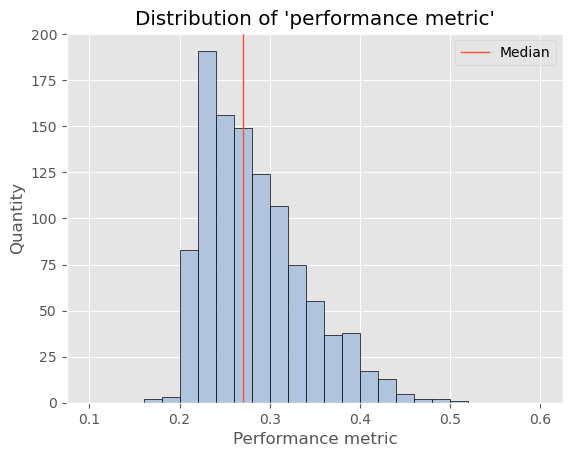

In [14]:
# Filter data for histogram
filtered_data = merged_df[merged_df['performance_metric'] > 0.05]['performance_metric'] 
median_performance = filtered_data.median()

#Calculate bins list
start, end, step = 0.1, 0.6, 0.025
bins = [round(x / 100, 2) for x in list(range(int(start * 100), int(end * 100) + 1, int(step * 100)))]

plt.style.use('ggplot')
plt.hist(filtered_data, bins=bins, edgecolor='black', color='lightsteelblue')
plt.axvline(median_performance, color='#fc4f30', linewidth=1, label='Median')
plt.legend()

plt.xlabel('Performance metric')
plt.ylabel('Quantity')
plt.title("Distribution of 'performance metric'")

plt.tight_layout
plt.show

##### Clubs with best performance_metric ratio (per 1 transfer)

In [15]:
# Group data by clubs and calculate 'transfer_performance_ratio' for each (mean value of performance_ratio / 1 transfer)
grouped_data = merged_df.groupby(by='transfers_teams_in_name')
transfer_counts = grouped_data['performance_metric'].count()
performance_sum = grouped_data['performance_metric'].sum()

performance_metric_ratio = performance_sum / transfer_counts


In [16]:
# Normalize data 
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(performance_metric_ratio.values.reshape(-1,1))

ratio_normalized = pd.Series(normalized_data.flatten(), index=performance_metric_ratio.index)


<function matplotlib.pyplot.show(close=None, block=None)>

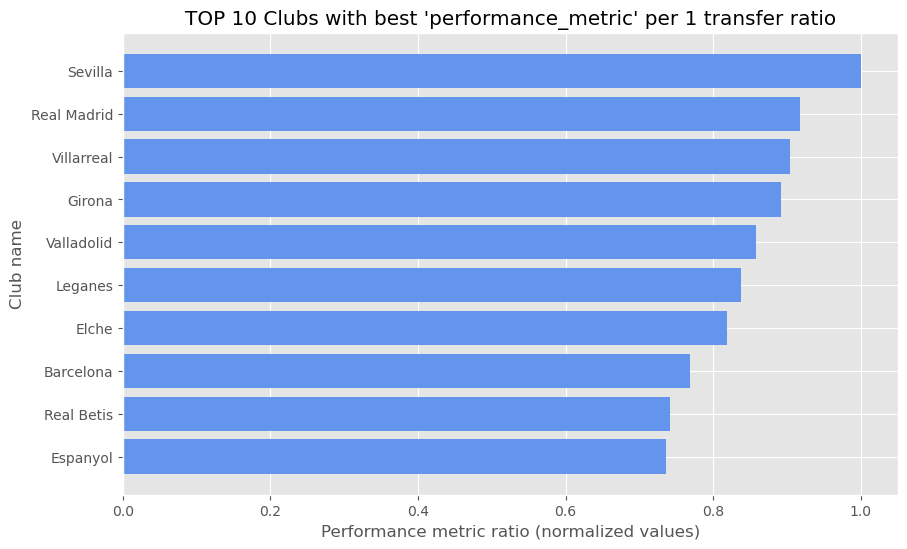

In [17]:
filtered_club_ratio = ratio_normalized.sort_values(ascending=False).head(10)

plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.barh(filtered_club_ratio.index, filtered_club_ratio, color='cornflowerblue')


plt.xlabel('Performance metric ratio (normalized values)')
plt.ylabel('Club name')
plt.title("TOP 10 Clubs with best 'performance_metric' per 1 transfer ratio")
plt.gca().invert_yaxis() 

plt.tight_layout
plt.show


#### 3.4 Transfers dynamics between clubs

In [19]:
# Create a DataFrame that contains info about transfers between pairs of clubs.
transfer_pairs = merged_df.groupby(by=['transfers_teams_in_name', 'transfers_teams_out_name']).agg({'player_id': 'count', 'transfer_fee': 'sum', 'performance_metric': 'sum', 'statistics_goals_total': 'sum'}).reset_index()
transfer_pairs.columns = ['transfers_teams_in_name', 'transfers_teams_out_name', 'transfers_count', 'total_transfers_fee', 'performance_metric_sum', 'goals_sum']

transfer_pairs['Pair'] = np.where(transfer_pairs['transfers_teams_in_name'] < transfer_pairs['transfers_teams_out_name'], 
                         transfer_pairs['transfers_teams_in_name'] + '-' + transfer_pairs['transfers_teams_out_name'],
                         transfer_pairs['transfers_teams_out_name'] + '-' + transfer_pairs['transfers_teams_in_name'])

# Group data by Pairs 
grouped_pairs = transfer_pairs.groupby('Pair').agg({'transfers_count': 'sum', 'total_transfers_fee': 'sum', 'performance_metric_sum': 'sum', 'goals_sum': 'sum'}).reset_index()

# Calculate additional columns
grouped_pairs['avg_transfer_fee'] = grouped_pairs['total_transfers_fee'] / grouped_pairs['transfers_count']
grouped_pairs['avg_performance_metric'] = grouped_pairs['performance_metric_sum'] / grouped_pairs['transfers_count']
grouped_pairs['avg_goals'] = grouped_pairs['goals_sum'] / grouped_pairs['transfers_count']

grouped_pairs.head(3)

,Pair,transfers_count,total_transfers_fee,performance_metric_sum,goals_sum,avg_transfer_fee,avg_performance_metric,avg_goals
0,AC Milan-Alaves,1,3.0,0.287311,1.0,3.0,0.287311,1.0
1,AC Milan-Atletico Madrid,2,15.0,0.589089,10.0,7.5,0.294545,5.0
2,AC Milan-Barcelona,1,0.0,0.266257,1.0,0.0,0.266257,1.0


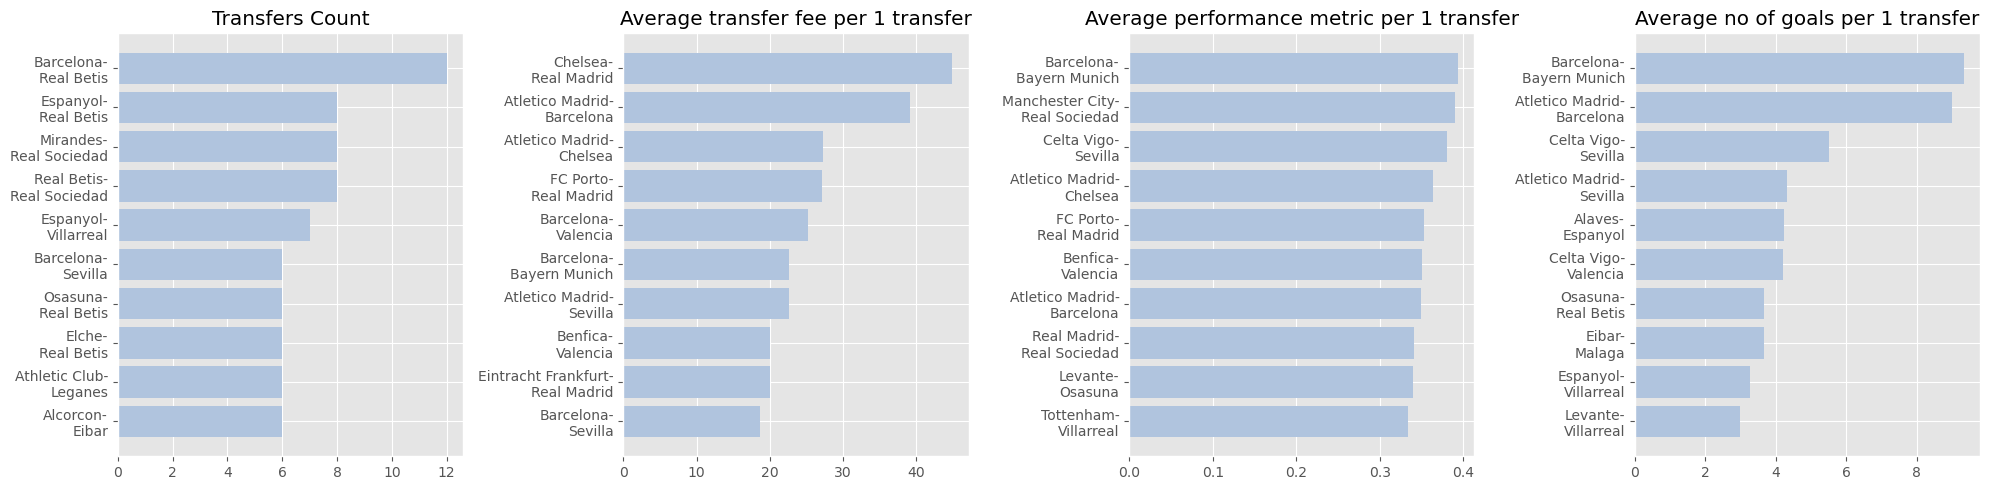

In [22]:
# Change display of 'Pair' to better readibility on chart
fixed_pairs = grouped_pairs.copy()
fixed_pairs['Pair'] = fixed_pairs['Pair'].str.replace('-', '-\n')

# Create ssequence of separate bar plots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plt.style.use('ggplot')

# Bar plot for 'transfers_count'
top_count = fixed_pairs.sort_values('transfers_count', ascending=False).head(10)
axs[0].barh(top_count['Pair'], top_count['transfers_count'], color='lightsteelblue')
axs[0].set_title('Transfers Count')
axs[0].invert_yaxis()

# Bar plot for 'transfer fee' per 1 transfer
top_avg_fee = fixed_pairs[fixed_pairs['transfers_count'] > 2].sort_values('avg_transfer_fee', ascending=False).head(10) # consider only pairs that made > 2 transfers
axs[1].barh(top_avg_fee['Pair'], top_avg_fee['avg_transfer_fee'], color='lightsteelblue')
axs[1].set_title('Average transfer fee per 1 transfer')
axs[1].invert_yaxis()

# Bar plot for 'performance_metric_sum' per 1 transfer
top_performance = fixed_pairs[fixed_pairs['transfers_count'] > 2].sort_values('avg_performance_metric', ascending=False).head(10) # consider only pairs that made > 2 transfers
axs[2].barh(top_performance['Pair'], top_performance['avg_performance_metric'], color='lightsteelblue')
axs[2].set_title('Average performance metric per 1 transfer')
axs[2].invert_yaxis()

# Bar plot for 'goals_sum' per 1 transfer
top_goals = fixed_pairs[fixed_pairs['transfers_count'] > 2].sort_values('avg_goals', ascending=False).head(10) # consider only pairs that made > 2 transfers
axs[3].barh(top_goals['Pair'], top_goals['avg_goals'], color='lightsteelblue')
axs[3].set_title('Average no of goals per 1 transfer')
axs[3].invert_yaxis()

plt.tight_layout()

plt.show()

##### Correlation between Total Transfer Fee, Performance Metric Sum and Goals Sum

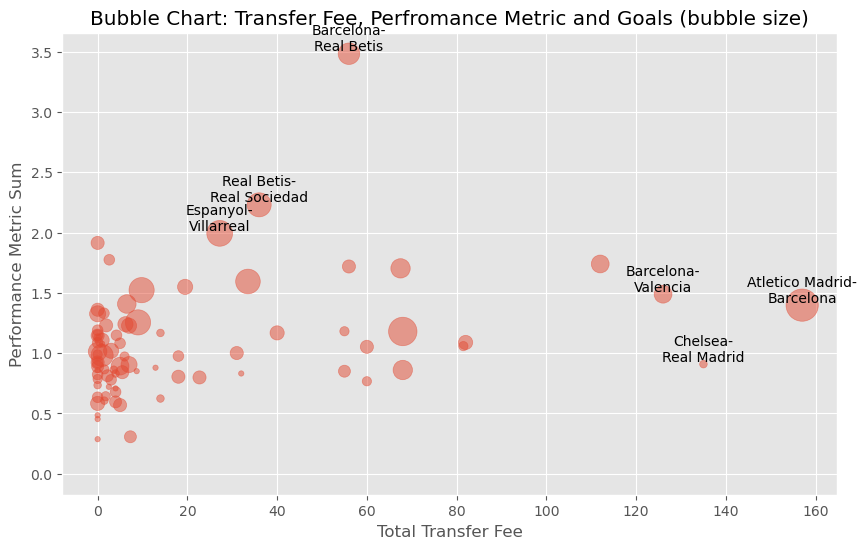

In [18]:
# Get Pairs with at least 3 transfers
most_transfers_pairs = grouped_pairs[grouped_pairs['transfers_count'] > 2].sort_values('total_transfers_fee')

x = most_transfers_pairs['total_transfers_fee']
y = most_transfers_pairs['performance_metric_sum']
bubble_size = most_transfers_pairs['goals_sum'] * 15

plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.scatter(x, y, s=bubble_size, alpha=0.5)

# Get labels for top 3 pairs for X and Y axis data
top_transfer_fee_pairs = most_transfers_pairs.sort_values('total_transfers_fee', ascending=False).head(3)
top_performance_pairs = most_transfers_pairs.sort_values('performance_metric_sum', ascending=False).head(3)

for i, row in top_transfer_fee_pairs.iterrows():
    label_text = row['Pair'].replace('-', '-\n')
    plt.annotate(label_text, (row['total_transfers_fee'], row['performance_metric_sum']), fontsize=10, ha='center', va='bottom')
    
for i, row in top_performance_pairs.iterrows():
    label_text = row['Pair'].replace('-', '-\n')
    plt.annotate(label_text, (row['total_transfers_fee'], row['performance_metric_sum']), fontsize=10, ha='center', va='bottom')

plt.xlabel('Total Transfer Fee')
plt.ylabel('Performance Metric Sum')
plt.title('Bubble Chart: Transfer Fee, Perfromance Metric and Goals (bubble size)')

plt.show()


#### 3.5 Questions

##### 1. Which club has payed most for 1 striker's goal  ?

In [18]:
filtered_df = merged_df.copy()
filtered_df = filtered_df[filtered_df['statistics_games_position'] == 'Attacker']
filtered_df['price_for_goal'] = filtered_df['transfer_fee'] / filtered_df['statistics_goals_total']
filtered_df['price_for_goal'].replace(np.inf, np.nan, inplace=True)
filtered_df = filtered_df.dropna(subset=['price_for_goal'])

print("\033[1m" + "TOP 10 most expensive strikers based on price per 1 goal" + "\033[0m")
filtered_df[['player_name', 'price_for_goal', 'transfers_teams_in_name', 'transfers_teams_out_name', 'season_of_transfer', 'transfer_fee', 'statistics_goals_total']].sort_values('price_for_goal', ascending=False).head(10)

TOP 10 most expensive strikers based on price per 1 goal


,player_name,price_for_goal,transfers_teams_in_name,transfers_teams_out_name,season_of_transfer,transfer_fee,statistics_goals_total
905,E. Hazard,100.0,Real Madrid,Chelsea,2019.0,100.0,1.0
1275,Malcom,41.0,Barcelona,Bordeaux,2018.0,41.0,1.0
1247,O. Dembélé,35.0,Barcelona,Borussia Dortmund,2017.0,105.0,3.0
922,L. Jović,30.0,Real Madrid,Eintracht Frankfurt,2019.0,60.0,2.0
910,Rodrygo,22.5,Real Madrid,Santos,2019.0,45.0,2.0
909,Vinícius Júnior,22.5,Real Madrid,Flamengo,2018.0,45.0,2.0
26,Diego Costa,22.0,Atletico Madrid,Chelsea,2017.0,66.0,3.0
60,João Félix,21.0,Atletico Madrid,Benfica,2019.0,126.0,6.0
31,L. Vietto,20.0,Atletico Madrid,Villarreal,2015.0,20.0,1.0
395,U. Sadiq,20.0,Real Sociedad,Almeria,2022.0,20.0,1.0


##### 2. What is the distribution of performance metric by age?

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9712\60394219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_group'] = ['Under 22' if age < 22 else


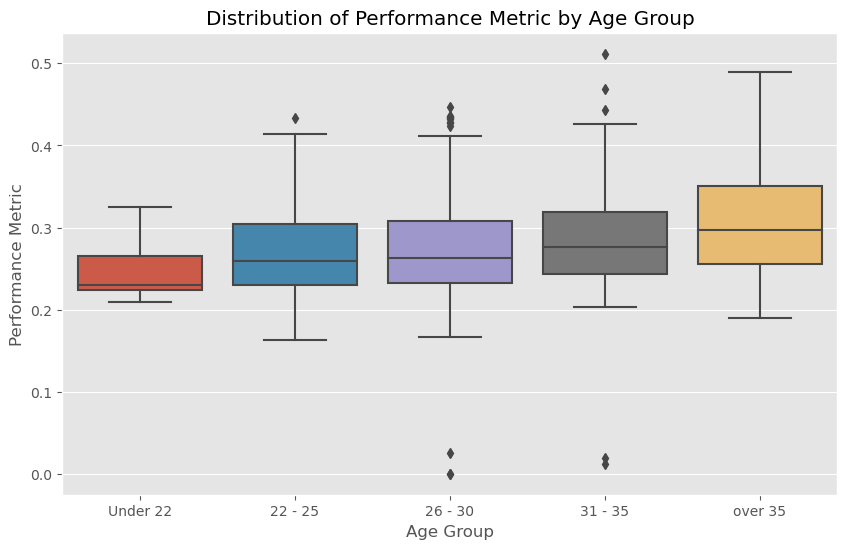

In [19]:
# Define age groups
filtered_df = merged_df[['player_name', 'player_age', 'statistics_games_rating', 'performance_metric']]
filtered_df['age_group'] = ['Under 22' if age < 22 else 
                            '22 - 25' if age in range(22, 26) else
                            '26 - 30' if age in range(26, 31) else
                            '31 - 35' if age in range(31, 36) else
                            'over 35' for age in filtered_df['player_age']]
filtered_df = filtered_df[filtered_df['performance_metric'] != 0.0] 

plt.style.use('ggplot')
plt.figure(figsize=(10,6))

sns.boxplot(data=filtered_df, x='age_group', y='performance_metric', order=['Under 22', '22 - 25', '26 - 30', '31 - 35', 'over 35' ])

plt.xlabel('Age Group')
plt.ylabel('Performance Metric')
plt.title('Distribution of Performance Metric by Age Group')
plt.show()


##### 3. Comparision of transfers from Spanish clubs and foreign transfers

In [14]:
# Create column for categorize transfers
merged_df['transfer_type'] = [None if np.isnan(id)  else
                              'Spanish' if id in df_spanish_teams['team#id'].unique() else
                              'Foreign' for id in merged_df['transfers_teams_out_id'].astype(float)]

# Drop Nones for futher analyse
category_df = merged_df.dropna(subset=['transfer_type'])

# Create grouped DF
category_df_grouped = category_df.groupby('transfer_type').agg({'statistics_games_rating': 'mean', 'transfer_fee': 'mean', 'statistics_goals_total': 'mean'})
category_df_grouped.columns = ['player_rating_avg', 'transfer_fee_avg', 'goals_total_avg']
category_df_grouped

,player_rating_avg,transfer_fee_avg,goals_total_avg
transfer_type,,,
Foreign,6.788591,9.737872,1.821206
Spanish,6.687511,4.221804,1.113997


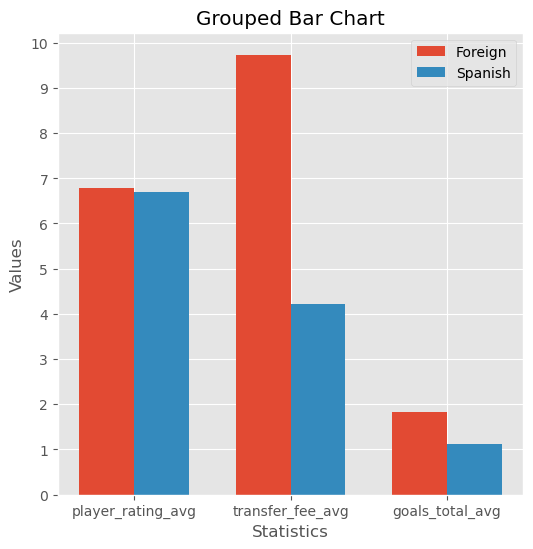

In [16]:
# Provide categories and data
x = np.arange(len(category_df_grouped.columns))
foreign_data = category_df_grouped.loc['Foreign'].values
spanish_data = category_df_grouped.loc['Spanish'].values

fig, ax = plt.subplots(figsize=(6, 6))
plt.style.use('ggplot')
width = 0.35

# Plot foreign data
ax.bar(x - width/2, foreign_data, width, label='Foreign')

# Plot spanish data
ax.bar(x + width/2, spanish_data, width, label='Spanish')

ax.set_xlabel('Statistics')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart')
ax.set_xticks(x)
ax.set_xticklabels(category_df_grouped.columns)
ax.set_yticks(np.arange(0, 11, 1))
ax.legend()

plt.show()

##### 4. Correlation between offensive statistics

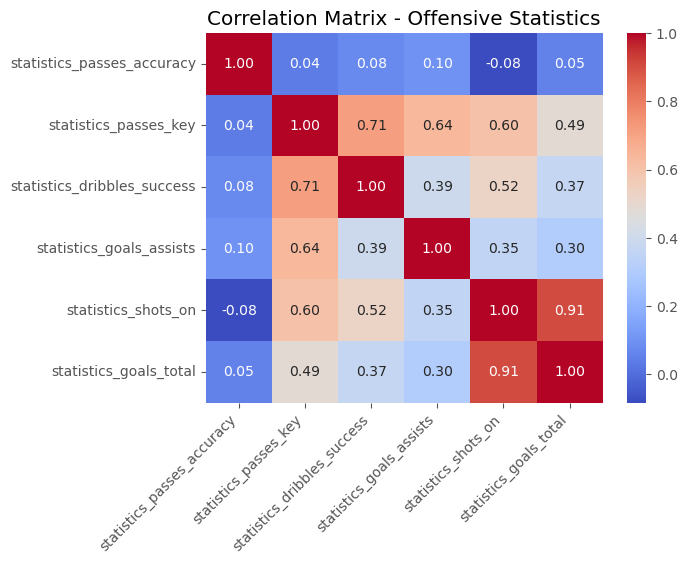

In [32]:
# Select statistics to correlation
selected_variables = [
    'statistics_passes_accuracy',
    'statistics_passes_key',
    'statistics_dribbles_success',
    'statistics_goals_assists',
    'statistics_shots_on',
    'statistics_goals_total'  
]

correlation_matrix = merged_df[selected_variables].corr()

# Create a heatmap for visualization
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Offensive Statistics")
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()